# Advanced Plotting

**BEFORE BEGINNING THIS EXERCISE** -  Check that your kernel (upper right corner, above) is `NPL 2023a`. This should be the default kernel, but if it is not, click on that button and select `NPL 2023a`.

_______________
This notebook provides some additional examples of more advanced sea ice fields. Here we introduce the concept of the subgridscale ice thickness distribution (ITD). This means we have a fraction of ice in each grid cell that is binned into thickness categories.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

For these exercises we will need to import multiple variables, below is an example of one way to do so.

In [2]:
monthly_output_path = "/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1"
run_name = "b.e21.BHISTcmip6.f09_g17.LE2-1001.001"

var_names = ['aice',
             'aicen',
             'vsnon',
             'hs',
             'fsens',
             'fsens_ai',
            ]

da_list = []

for var_name in var_names:
    files = os.path.join(monthly_output_path, var_name,
                         run_name + ".cice.h." + var_name + ".*")
    ds_in = xr.open_mfdataset(files)
    da_list.append(ds_in[var_name])
    del ds_in

ds = xr.merge(da_list)

del da_list

The next step is to read in some grid information for the `gx1v7` dipole grid used in POP and CICE. We will read in three main variables: `tarea`, `TLAT`, and `TLON`. These are the areas of the gridcells along with the latitudes and longitudes of the gridcell centers. Also, we will print the latitude array `TLAT` to see the metadata.

In [3]:
# get pop grid grid cell areas
grid = pop_tools.get_grid('POP_gx1v7')

# convert tarea to m^2
with xr.set_options(keep_attrs=True):
    grid['TAREA'] = grid['TAREA']/(1e4)
grid['TAREA'].attrs['units'] = 'm^2'

We will merge in three main variables: `tarea`, `TLAT`, and `TLON`. These are the areas of the gridcells along with the latitudes and longitudes of the gridcell centers. Note that this overwrites the dataset object from above.

In [4]:
ds = xr.merge([ds.drop(['TLAT', 'TLON', 'ULAT', 'ULON']),
               grid[['TLAT', 'TLONG', 'TAREA']].rename_dims({'nlat':'nj','nlon':'ni'})],
              compat='identical', combine_attrs='no_conflicts')

In [5]:
ds

<xarray.Dataset>
Dimensions:   (time: 1980, nj: 384, ni: 320, nc: 5)
Coordinates:
  * time      (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    NCAT      (nc) float32 dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: nj, ni, nc
Data variables:
    aice      (time, nj, ni) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    aicen     (time, nc, nj, ni) float32 dask.array<chunksize=(120, 5, 384, 320), meta=np.ndarray>
    vsnon     (time, nc, nj, ni) float32 dask.array<chunksize=(120, 5, 384, 320), meta=np.ndarray>
    hs        (time, nj, ni) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    fsens     (time, nj, ni) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    fsens_ai  (time, nj, ni) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    TLAT      (nj, ni) float64 -79.22 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG     (nj, ni) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TAREA     (nj, ni) float64 1.125e+09 1.125e+09 ... 7.431e+08 7.432e+08
Attributes: (12/13)
    units:              1
    long_name:          ice area  (aggregate)
    cell_measures:      area: tarea
    cell_methods:       time: mean
    time_rep:           averaged
    lateral_dims:       [384, 320]
    ...                 ...
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

_______________
## Example 1: Plot per-category ice area

Compare the dataset in this notebook with `aice` in the basics notebook. Notice that in this case we have an additional category dimension `nc`. `aicen` is the per-category ice area fraction. We demonstrate plotting a per-category variable below. We also plot the full sea ice concentration in the final plot.

Text(0.5, 1.0, 'Sea Ice Concentration')

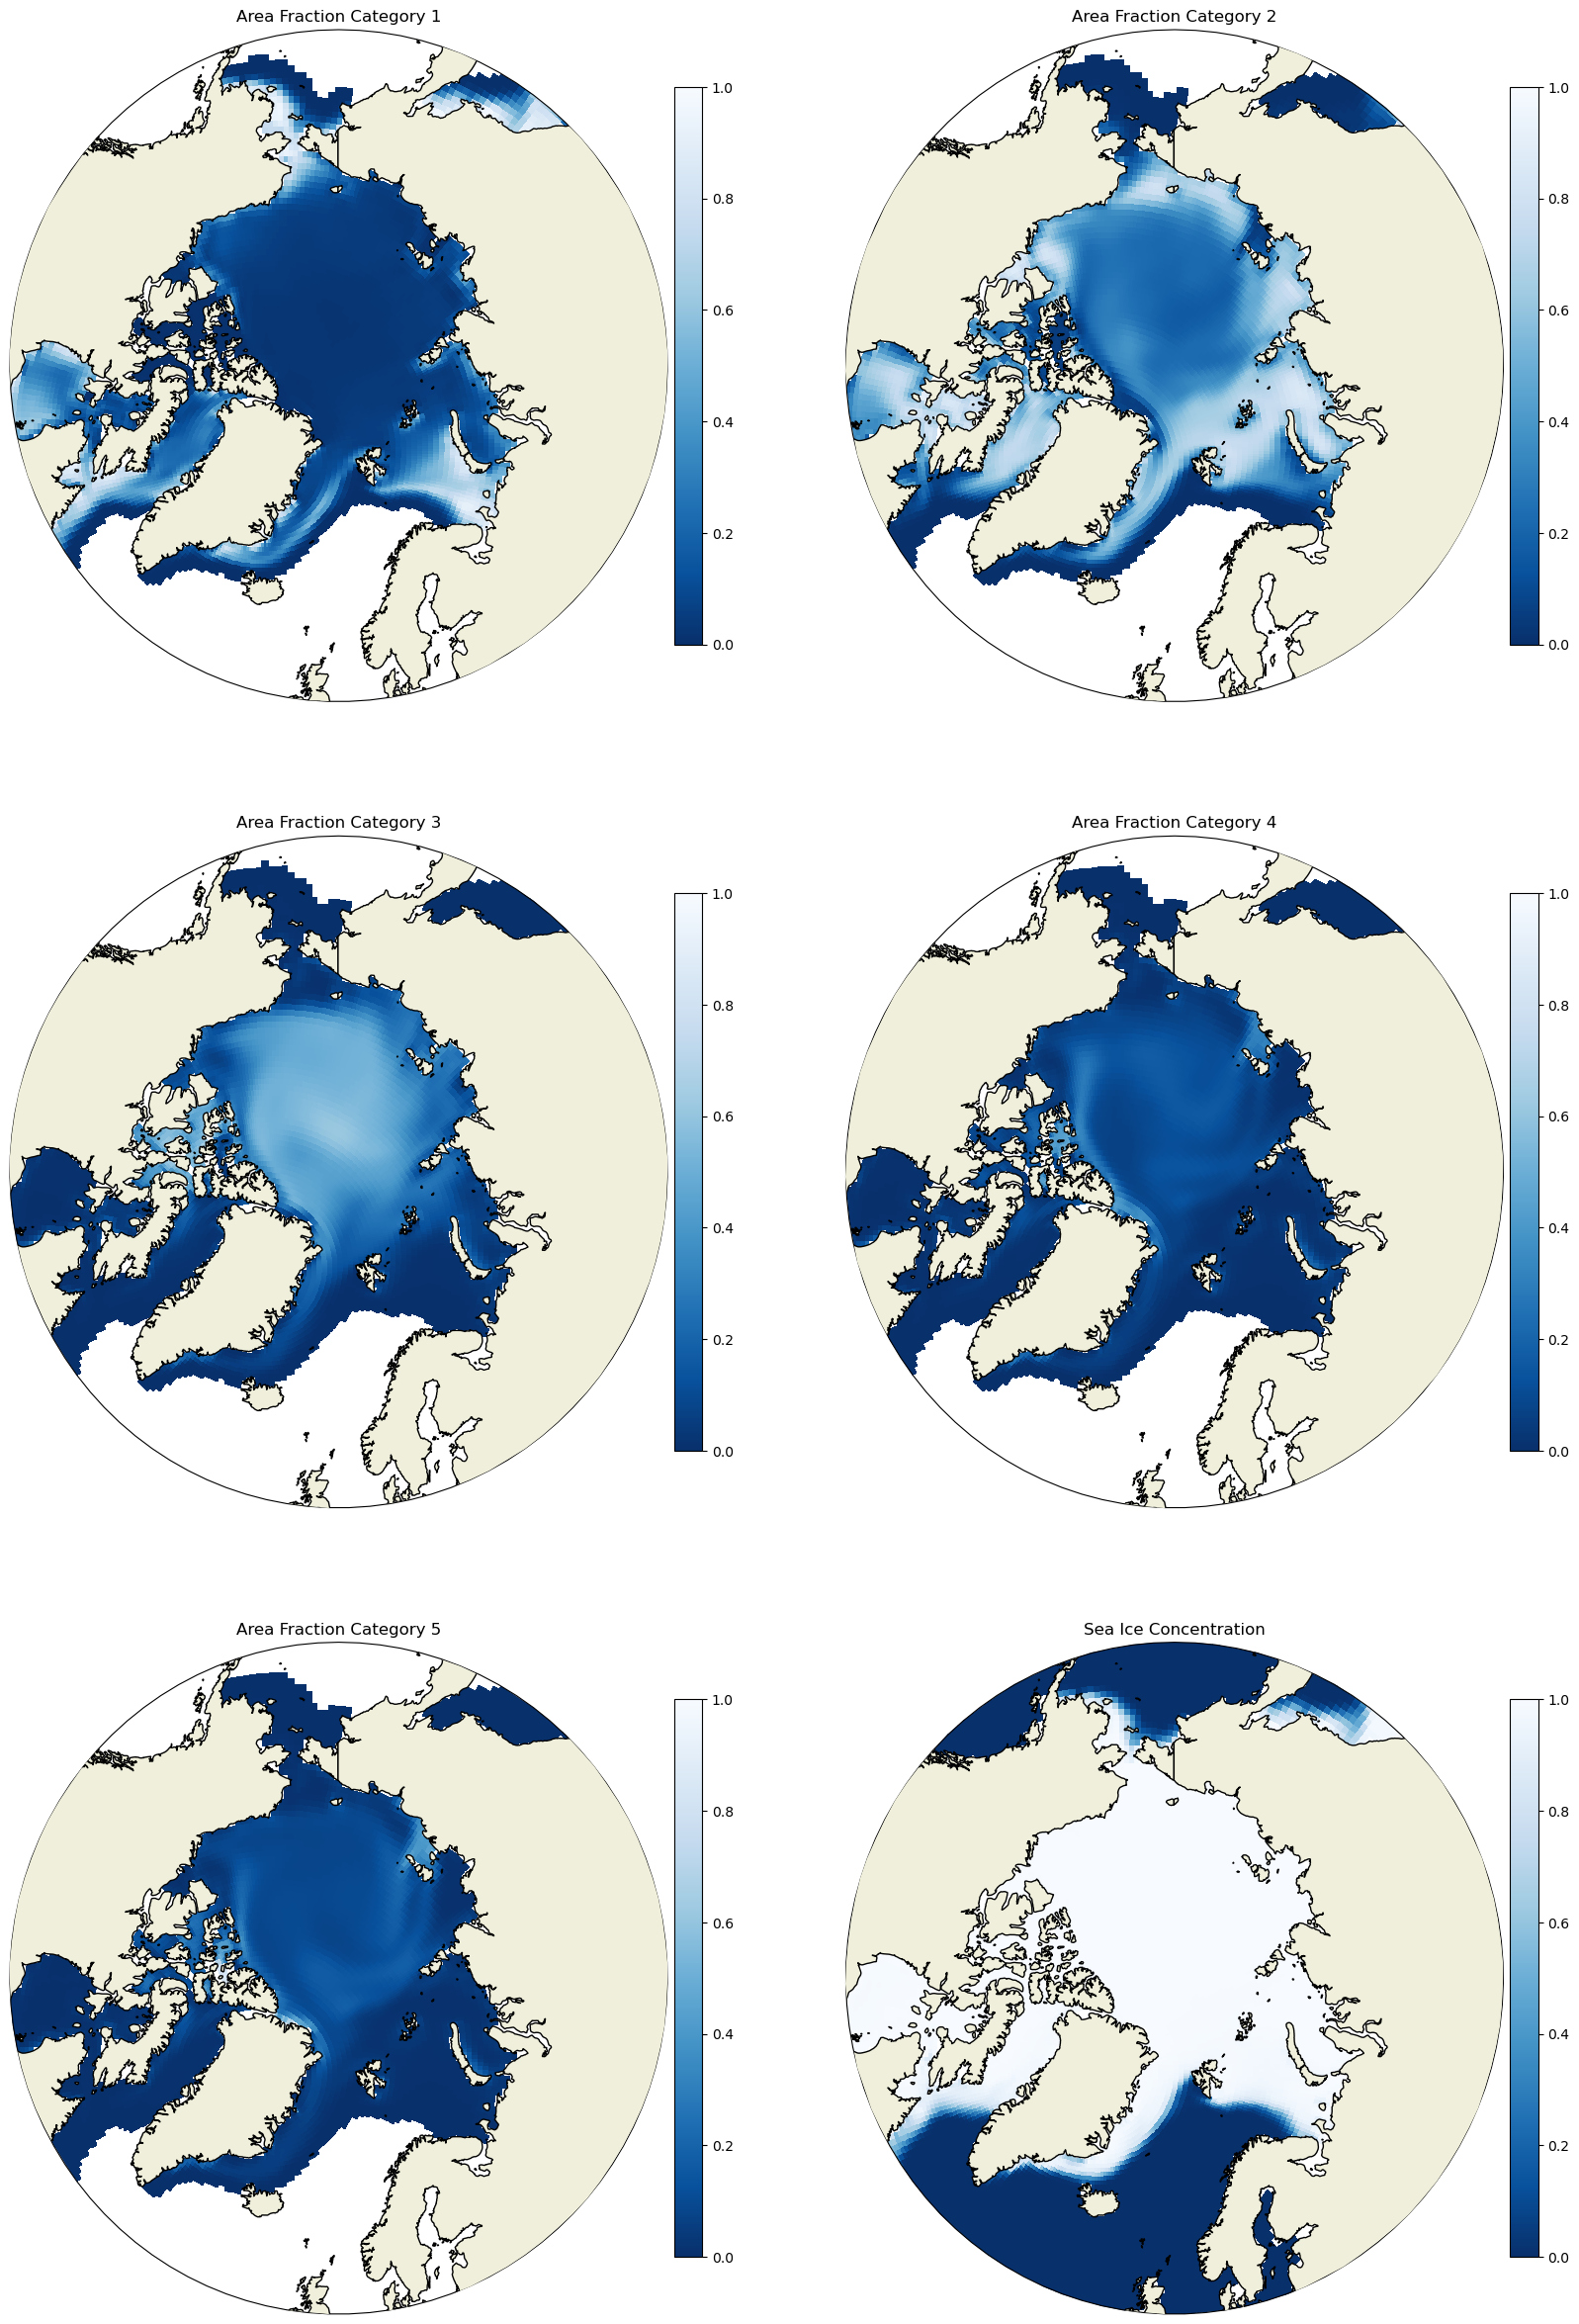

In [6]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

cmap = plt.cm.get_cmap('Blues_r')  

# create figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(20,30),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
axs = np.ravel(axs)

# this creates a subplot for each ITD category
for i in ds.nc.values:
    ax = axs[i]
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
    this=ax.pcolormesh(ds['TLONG'],
                       ds['TLAT'],
                       ds['aicen'].sel({'time':'1850-02-01 00:00:00',
                                        'nc':i}).squeeze(),
                       cmap=cmap,vmax=1,vmin=0,
                       transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    ax.set_title('Area Fraction Category ' + str(i+1))

# gridcell mean aice in the final subplot
ax = axs[-1]
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
this=ax.pcolormesh(ds['TLONG'],
                   ds['TLAT'],
                   ds['aice'].sel({'time':'1850-02-01 00:00:00'}).squeeze(),
                   cmap=cmap,vmax=1,vmin=0,
                   transform=ccrs.PlateCarree())
plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
ax.set_title('Sea Ice Concentration')

<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution to final two panels</font></summary><br>

![plot example](../../../images/diagnostics/cice/advanced_plot_1.png)

*<p style="text-align: center;"> Figure: Plotting solution. </p>*
    
</details>
</div>

### Question:

How do you get the grid cell total sea ice concentration? In which of the thickness categories is the concentration highest? How does that vary spatially? What does this indicate about the relative importance of different ice thicknesses in different Arctic regions?

Note that the default CICE ice thickness categories are:
- Category 1: 0-0.64 m
- Category 2: 0.64-1.39 m
- Category 3: 1.39-2.47 m
- Category 4: 2.47-4.57 m
- Category 5: 4.57+ m

<div class="alert alert-warning">  
<details>

<summary> <font face="Times New Roman" color='blue'>Click here for hints</font> </summary>

You would calculate the grid cell total sea ice concentration by summing up the concentration in each category. In the central Arctic the concentrations are highest in categories 2 and 3, while on the ice margines the concentrations are highest in category 1. The only location with any substantial thick ice (category 5) is the central Arctic. This indicates that different regions sea ice are dominated by very different mean sea ice thickness. This will have implications for ice growth/melt and heat fluxes.
    
    
</details>
</div>

_______________
## Example 2: Plot per-category snow thickness

Internally, the model actually stores the snow **volume** for each category, not the thickness. To get the thickness we need to divide `vsnon` by `aicen` (the per category area).

In [7]:
ds['hsn'] = ds['vsnon'] / ds['aicen']

Text(0.5, 1.0, 'Average Snow Depth (m)')

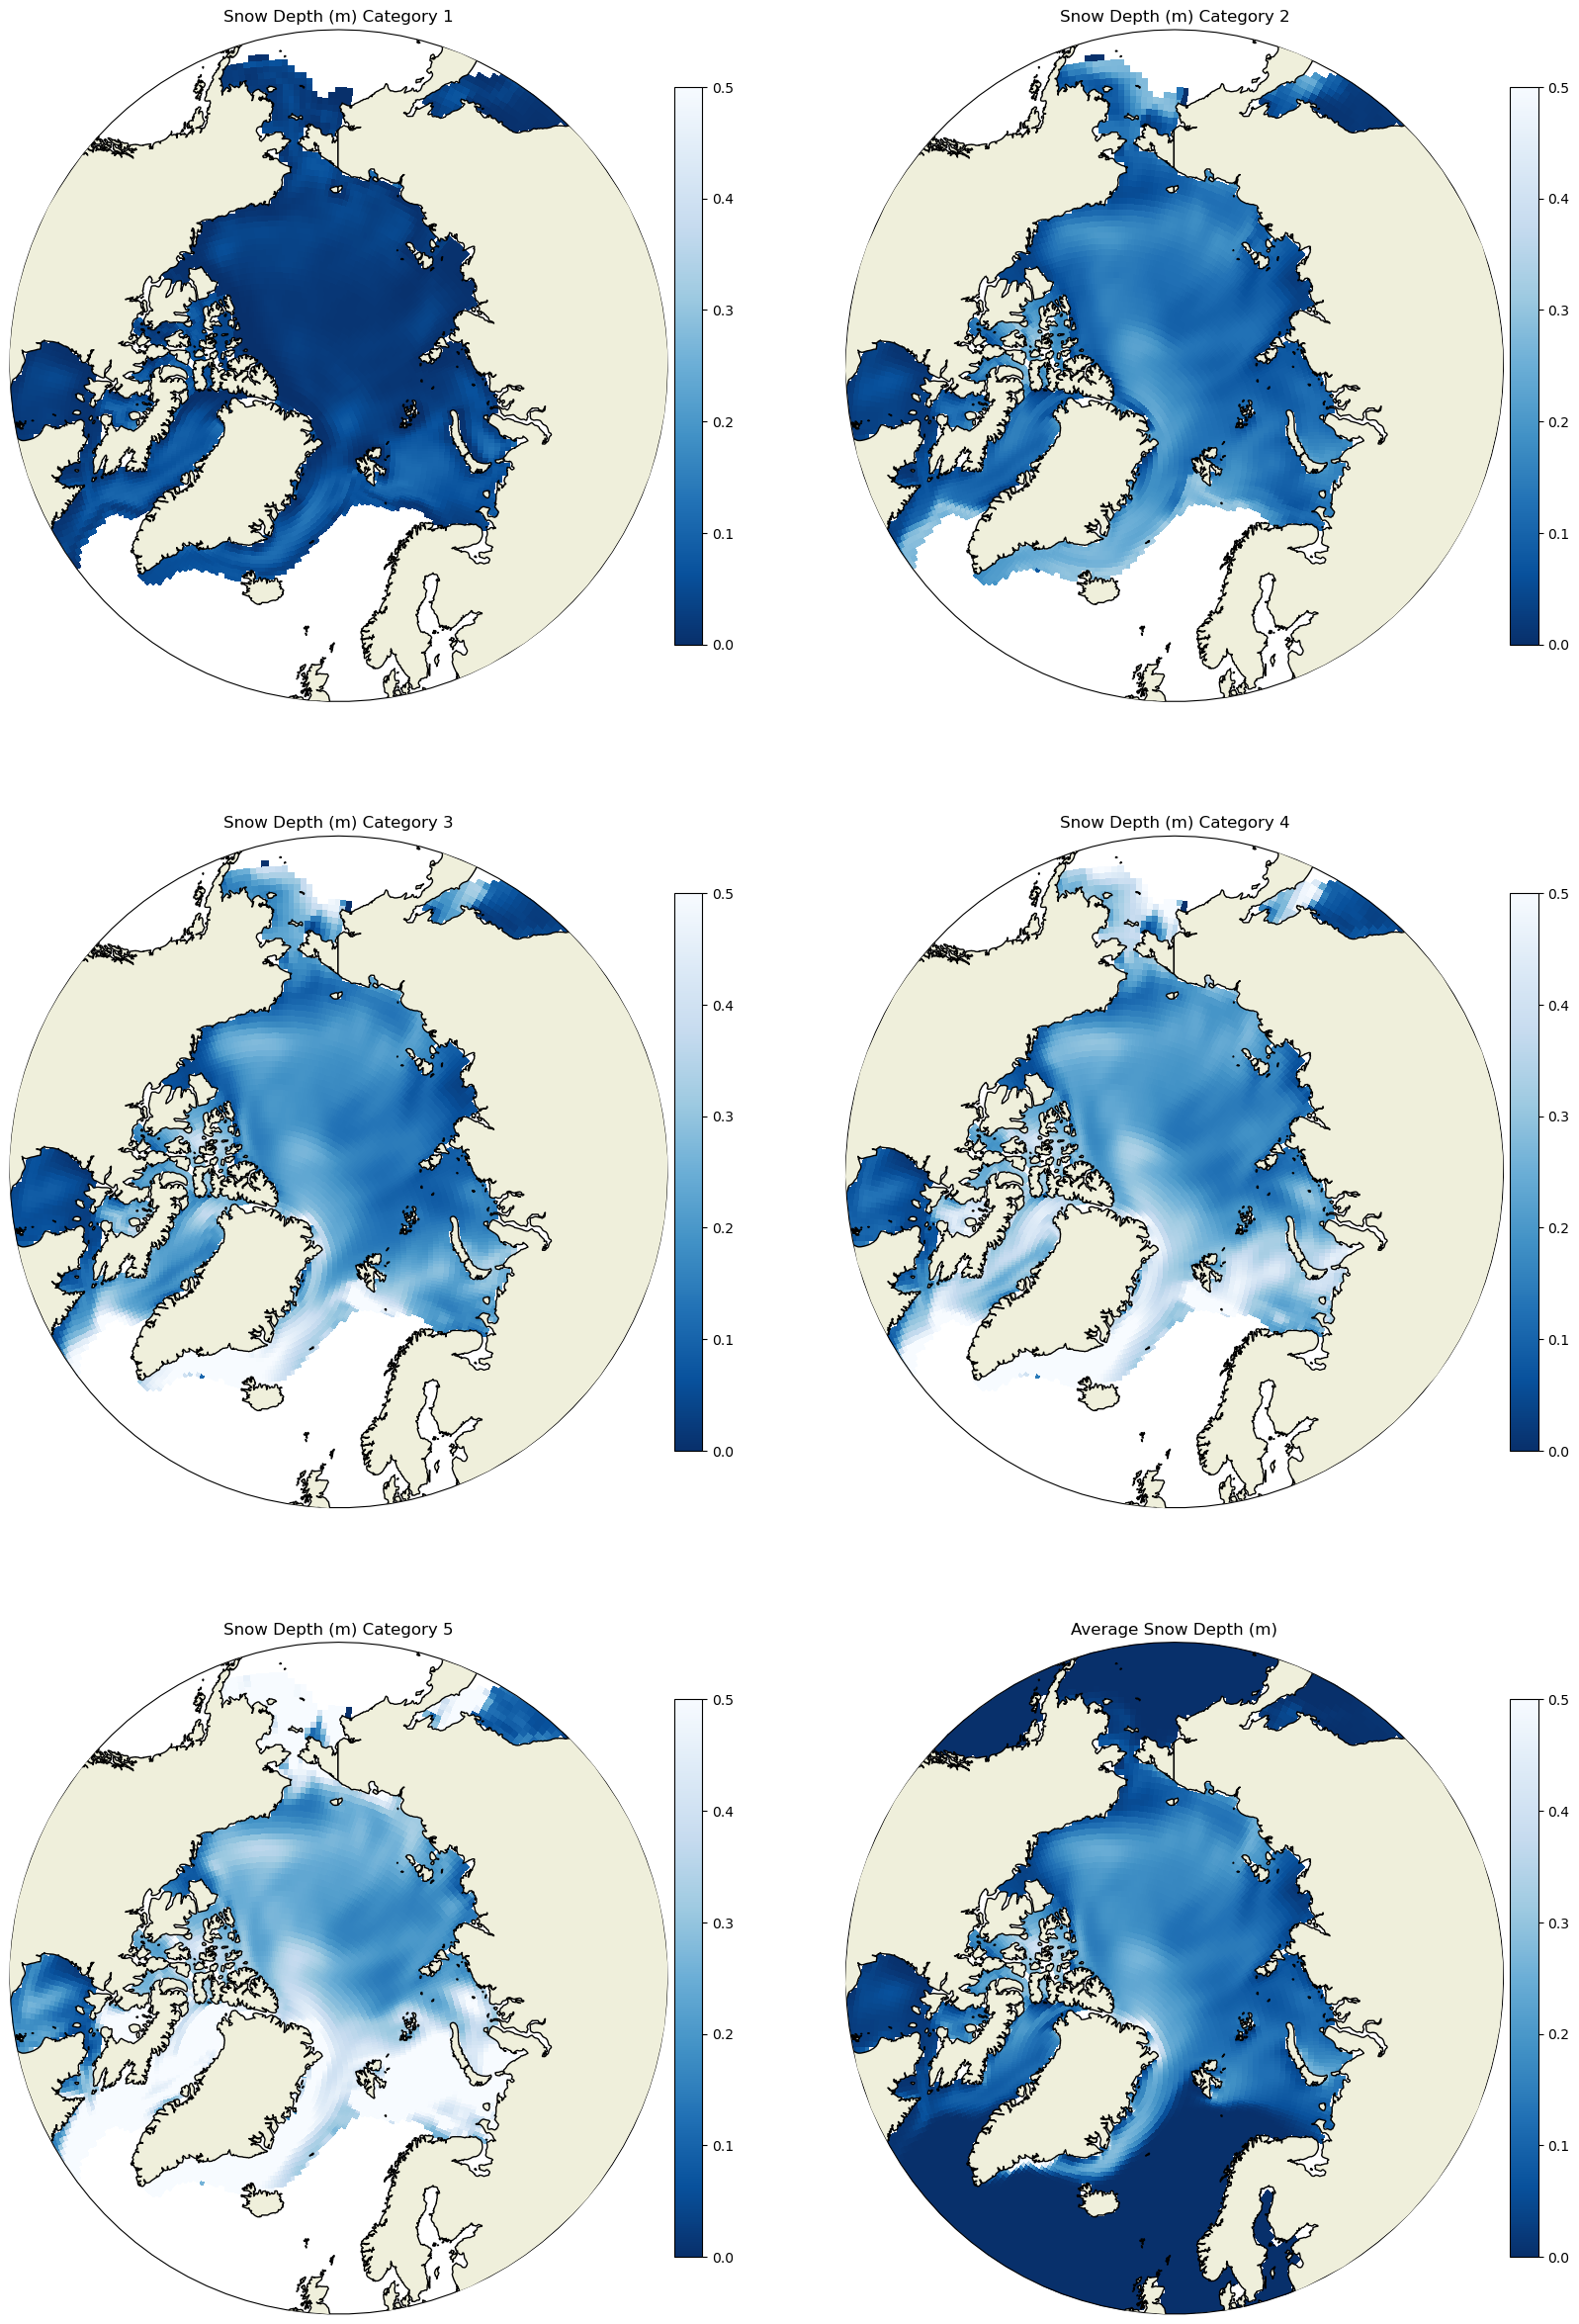

In [8]:
# Max snow depth for colorbars
hs_max = 0.5 

# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

cmap = plt.cm.get_cmap('Blues_r')  


fig, axs = plt.subplots(3, 2, figsize=(20,30),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
axs = np.ravel(axs)

for i in ds.nc.values:
    ax = axs[i]
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
    this=ax.pcolormesh(ds['TLONG'],
                       ds['TLAT'],
                       ds['hsn'].sel({'time':'1850-02-01 00:00:00',
                                        'nc':i}).squeeze(),
                       cmap=cmap,vmax=hs_max,vmin=0,
                       transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    ax.set_title('Snow Depth (m) Category ' + str(i+1))

# gridcell mean snow volume in the final subplot
ax = axs[-1]
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
this=ax.pcolormesh(ds['TLONG'],
                   ds['TLAT'],
                   ds['hs'].sel({'time':'1850-02-01 00:00:00'}).squeeze(),
                   cmap=cmap,vmax=hs_max,vmin=0,
                   transform=ccrs.PlateCarree())
plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
ax.set_title('Average Snow Depth (m)')

<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution to final two panels</font></summary><br>

![plot example](../../../images/diagnostics/cice/advanced_plot_2.png)

*<p style="text-align: center;"> Figure: Plotting solution. </p>*
    
</details>
</div>

### Question:

In addition to the per-category snow thickness values we plotted the grid cell mean snow thickness. How do these values compare?

<div class="alert alert-warning">  
<details>

<summary> <font face="Times New Roman" color='blue'>Click here for hints</font> </summary>

The per-category snow thickness can be higher than the grid cell mean (see Category 4 and the grid cell mean). This means the thicker ice tends to have thicker snow, but if the overall concentration of the thick ice categories is small then the mean over the grid call can be lower.
    
    
</details>
</div>

_______________
## Example 3: Ice area related tracer

The default CICE outputs are averaged over the entire grid cell, including the open water. Thus if a grid cell happened to be half covered in 1-m-thick ice and half open water then `hi` would be 0.5 m. Some tracers are written out just for the ice-covered area of the grid cell. These are indicated by have `_ai` appended to the variable name.

Below is an example of this for the sensible heat flux.

In [9]:
ds['fsens_diff'] = ds['fsens_ai'] - ds['fsens']

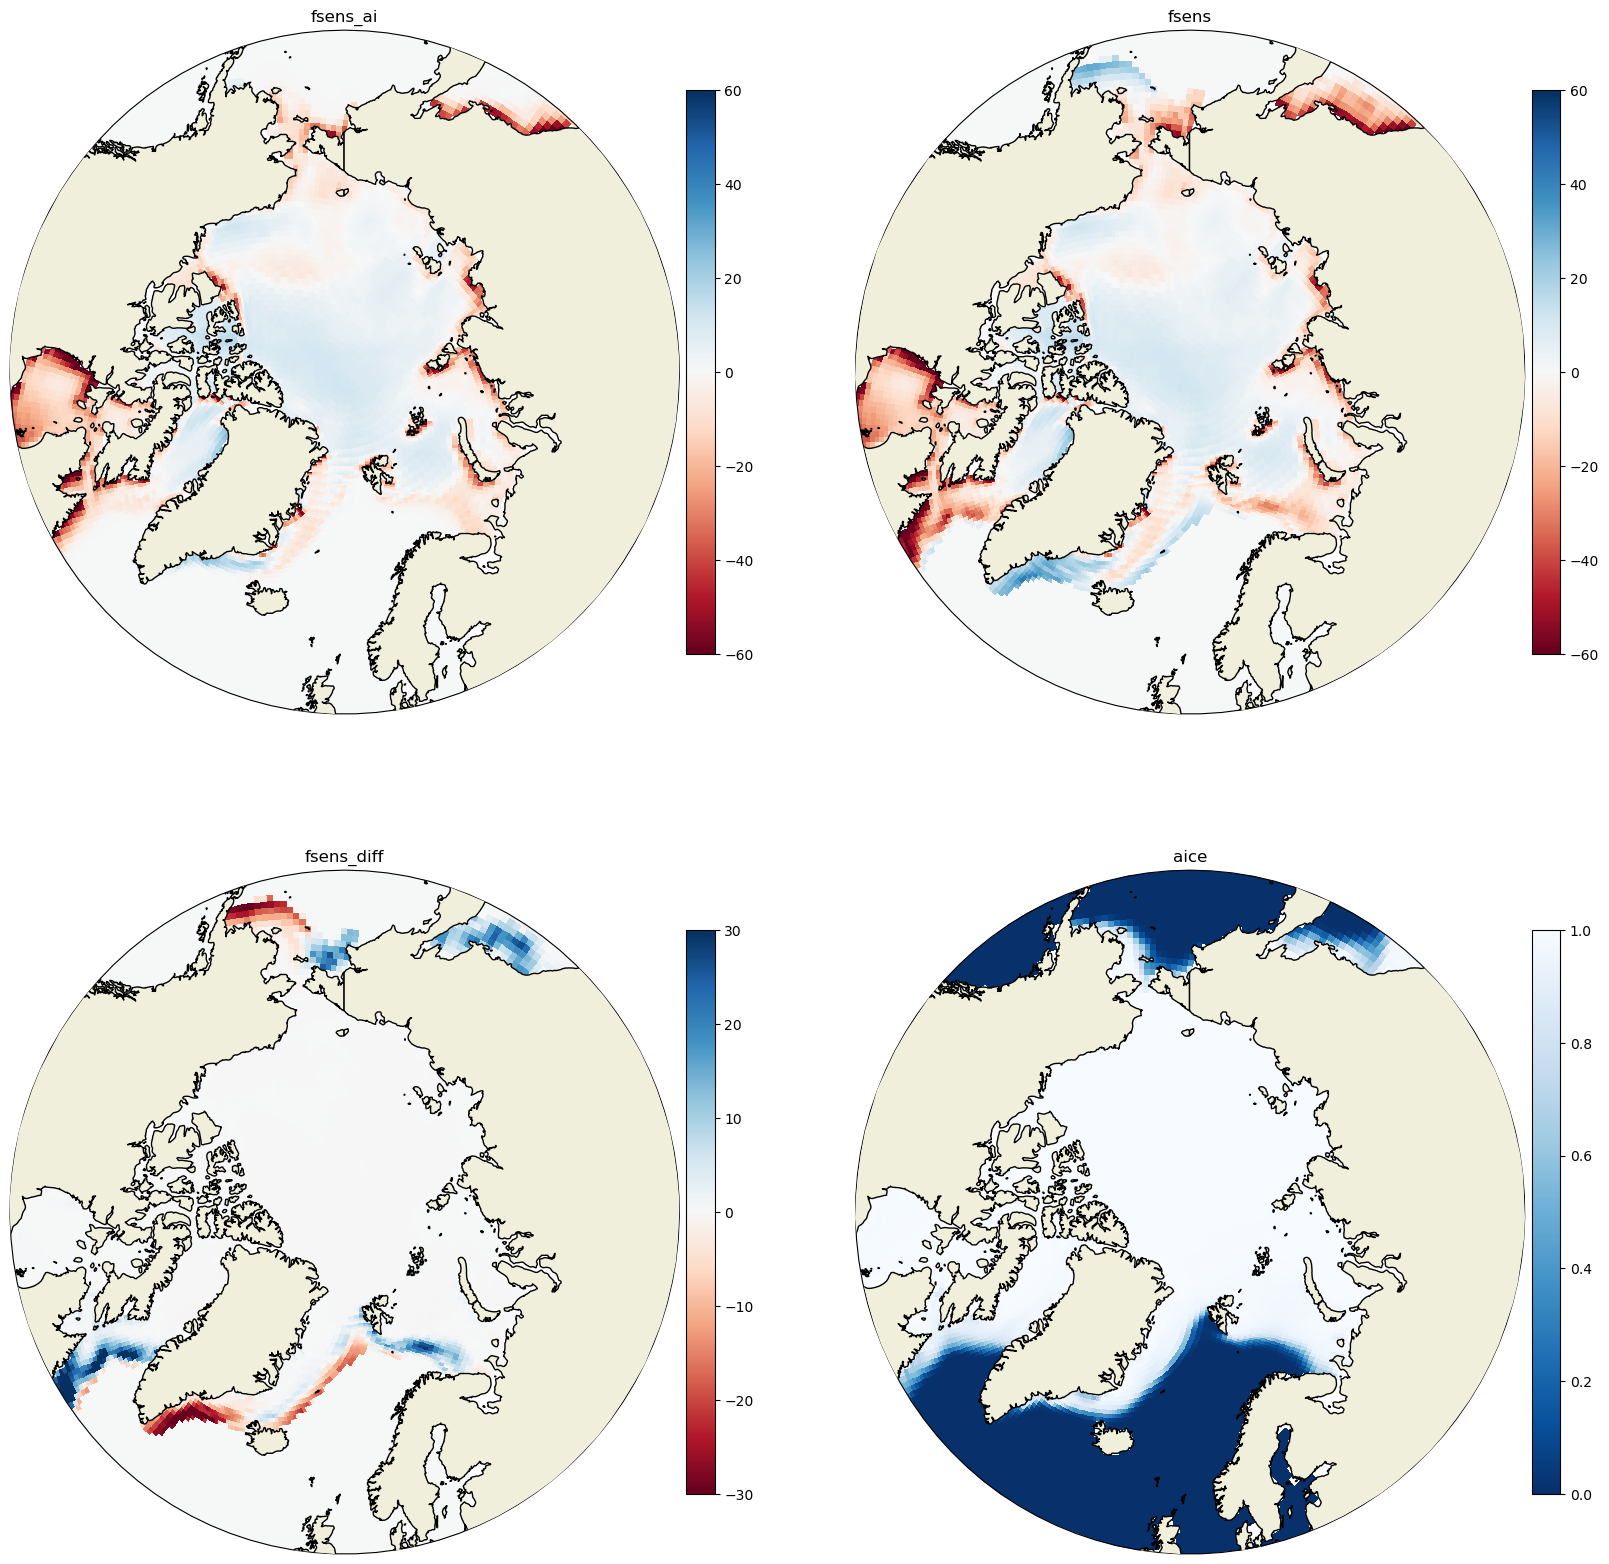

In [10]:
# Min and max
mins = [-60, -60, -30, 0]
maxs = [60, 60, 30, 1]

# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

cmap = plt.cm.get_cmap('RdBu')  

vars_to_plt = ['fsens_ai', 'fsens', 'fsens_diff', 'aice']

fig, axs = plt.subplots(2, 2, figsize=(20,20),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
axs = np.ravel(axs)

# set up the plots for sensible heat flux over the sea ice, gridcell mean sensible heat flux,
# difference, and the gridcell mean ice concentration aice

for i in np.arange(4):
    if i == 3:
        cmap = plt.cm.get_cmap('Blues_r')
    ax = axs[i]
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
    this=ax.pcolormesh(ds['TLONG'],
                       ds['TLAT'],
                       ds[vars_to_plt[i]].sel({'time':'1850-02-01 00:00:00'}
                                             ).squeeze(),
                       cmap=cmap,vmax=maxs[i],vmin=mins[i],
                       transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    ax.set_title(vars_to_plt[i])



<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution to final two panels</font></summary><br>

![plot example](../../../images/diagnostics/cice/advanced_plot_3.png)

*<p style="text-align: center;"> Figure: Plotting solution. </p>*
    
</details>
</div>

### Question:

Where are the differences in the fluxes most pronounced and why?

<div class="alert alert-warning">  
<details>

<summary> <font face="Times New Roman" color='blue'>Click here for hints</font> </summary>

The differences are most pronounced near the ice edge where ice concentrations are lowest. This is because these areas have a lot of open water so the grid cell mean flux will be very different than that over just the ice covered portion. In the central Arctic most cells are nearly all ice covered, so the fluxes are not substantially different.
    
    
</details>
</div>

_______________
## Example 4: Remapping a sea ice gridded field

The sea ice and ocean grids usually have a transformation where the grid North Pole is moved into land to avoid instability problems with converging meridians [Orthogonal Grids - Murray 1996](https://doi.org/10.1006/jcph.1996.0136). In the CESM we use the POP dipole and tripole grids and will soon be using the MOM6 tripole grids. While matplotlib can actually use the 2D latitude and longitude fields to make plots, it is sometimes necessary to remap or regrid the data onto a standard latitude-longitude grid. This can be using using the ESMF remapping tools [xESMF](https://xesmf.readthedocs.io/en/latest/) for python.

Let's first plot the raw field so the dipole grid can be visualized.

In [11]:
aice = ds['aice']

aice

<xarray.DataArray 'aice' (time: 1980, nj: 384, ni: 320)>
dask.array<concatenate, shape=(1980, 384, 320), dtype=float32, chunksize=(120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

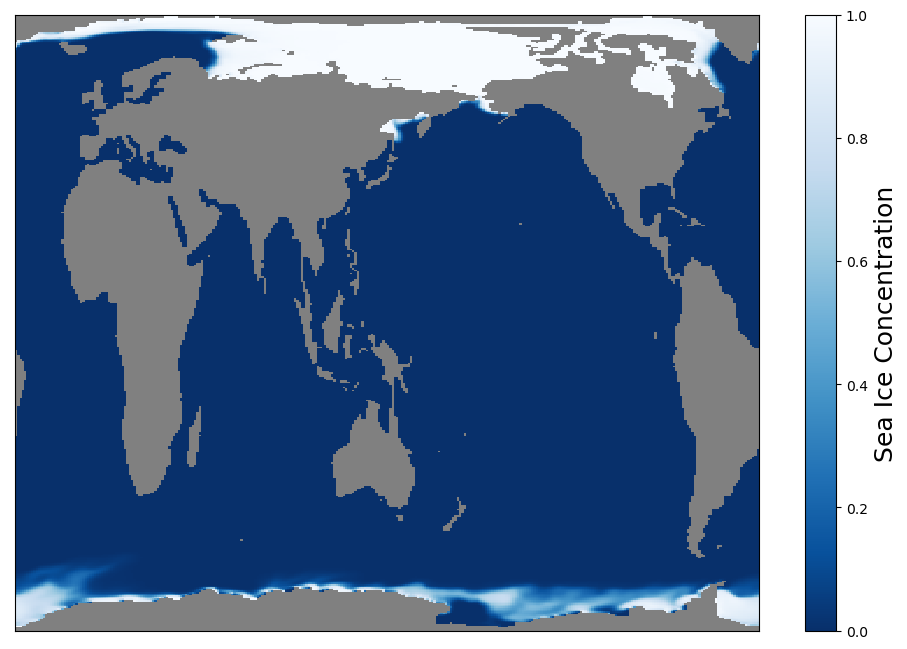

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_facecolor('0.5') # Fill in model land by making the axis background whatever color you want
im1 = ax.pcolormesh(ds.coords['ni'],ds.coords['nj'],aice[0],cmap='Blues_r',vmin=0,vmax=1)
cbar = plt.colorbar(im1)
cbar.set_label('Sea Ice Concentration',fontsize=18)
plt.xticks([]);
plt.yticks([]);

<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

![plot example](../../../images/diagnostics/cice/advanced_plot_4.png)

*<p style="text-align: center;"> Figure: Plotting solution. </p>*
    
</details>
</div>

### Question:

What do you notice about the Northern Hemisphere? What is going on with Greenland? Do you notice anything odd in the Southern Hemisphere?

<div class="alert alert-warning">  
<details>

<summary> <font face="Times New Roman" color='blue'>Click here for hints</font> </summary>

See how the Northern Hemisphere looks weird? Greenland is stretched completely across the top edge of the plot. In contrast, the Southern Hemisphere looks normal.
    
</details>
</div>

Next we will import the `xesmf` library and create a "destination" grid. This is just a simple one-degree by one-degree latitude longitude grid.

In [14]:
import xesmf as xe

In [15]:
# Setting up a target grid to only regrid the sea ice data
lat=np.arange(-90,90,1.0) 
lon=np.arange(0,361,1.0)
#create a meshgrid (2D fields of lats and lons)
lon2d,lat2d=np.meshgrid(lon,lat) 
#set up the target grid as an xarray Dataset
target_grid=xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})

target_grid

<xarray.Dataset>
Dimensions:  (y: 180, x: 361)
Dimensions without coordinates: y, x
Data variables:
    lat      (y, x) float64 -90.0 -90.0 -90.0 -90.0 ... 89.0 89.0 89.0 89.0
    lon      (y, x) float64 0.0 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0

Now we need to create a Dataset. For some reason the regridder does not accept a DataArray.

In [16]:
# Define the dataset and a variable `aice` with dimensions time, nj, and ni. Also, fill the
# lat and lon arrays from the POPgrid dataset.

ds_siconc_ocean               = xr.Dataset()
ds_siconc_ocean['aice']     = (('time','nj','ni'),ds['aice'].values)
ds_siconc_ocean.coords['lat'] = (('nj','ni'),grid['TLAT'].values)
ds_siconc_ocean.coords['lon'] = (('nj','ni'),grid['TLONG'].values)
sic_ocean                     = ds_siconc_ocean['aice']

Next we will use xesmf to regrid from the POP gx1v7 grid to the one degree by one degree regular grid.

In [17]:
#input grid, output grid, method, keyword arguments
regridder=xe.Regridder(sic_ocean[0,:,:], target_grid, 'nearest_s2d',periodic=True,reuse_weights=False)

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/xarray/core/dataarray.py:866: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Now that we have the mapping or regridder. We can translate the Xarray Dataset from gx1v7 to one-degree regular grid.

In [18]:
sic_rg = regridder(sic_ocean)

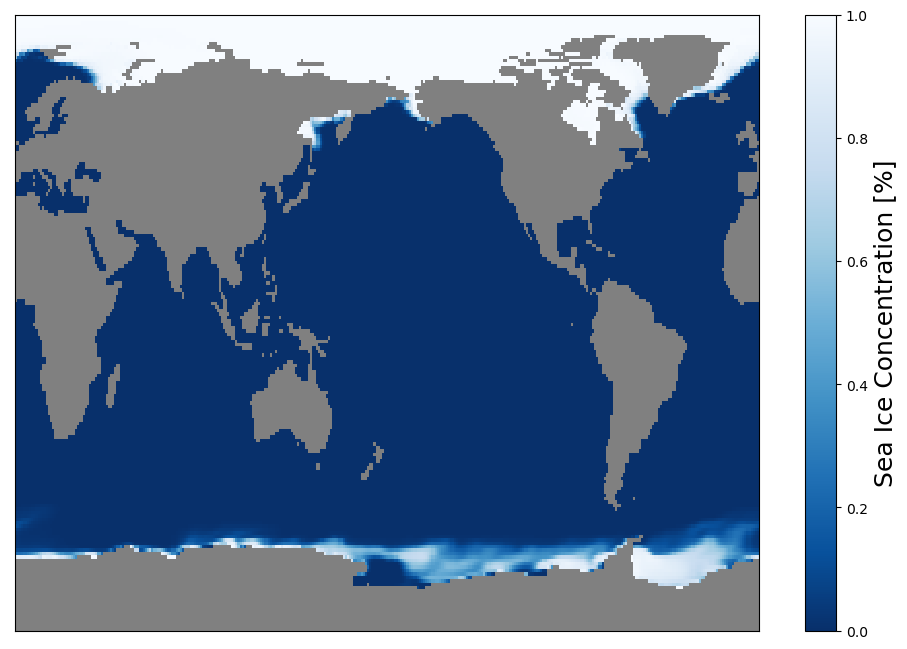

In [19]:
# Plot the first slice of the new dataset.
fig, ax = plt.subplots(figsize=(12,8))
ax.set_facecolor('0.5') # Fill in model land by making the axis background whatever color you want
im4 = ax.pcolormesh(lon,lat,sic_rg[0,:,:],cmap='Blues_r',vmin=0,vmax=1)
cbar = plt.colorbar(im4)
cbar.set_label('Sea Ice Concentration [%]',fontsize=18)
plt.xticks([]);
plt.yticks([]);

<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

![plot example](../../../images/diagnostics/cice/advanced_plot_5.png)

*<p style="text-align: center;"> Figure: Plotting solution. </p>*
    
</details>
</div>

### Question:

What do you notice about the Northern Hemisphere now?

<div class="alert alert-warning">  
<details>

<summary> <font face="Times New Roman" color='blue'>Click here for hints</font> </summary>

See how the Northern Hemisphere looks weird? Greenland is stretched completely across the top edge of the plot. In contrast, the Southern Hemisphere looks normal.
    
</details>
</div>

What do you notice about the top of the domain in the plot? Now this could be differenced against an observational dataset on a one-degree grid.